# Study of the Swiss electrical mix (and imports) between 2016 and 2021

This notebook is a study of the Swiss electrical mix (production and imports) between 2016 and 2021. It aims to represent the repartition of the consumed electricity and the associated ghg emissions.
It illustrates some possible uses of EcoDynElec.

We perform a historical analysis of the Swiss energy mix over 5 years, between 2016 and 2021. We have hourly European electricity production and exchange data, from which we calculate the Swiss electricity mix and its carbon impact (in grams of CO2 per kWh).
We mainly use two information types:
- The **producer mix** refers to the electricity produced in the designated country. It contains only local sources. When converting the producer mix into kWh, we obtain the **electricity production** of the country.
- The **consumer mix** refers to the electricity consumed in the designated country. It contains local sources as well as the import of electricity from other countries. When converting the consumer mix into kWh, we obtain the **electricity consumption** of the country.

These data make it possible to calculate the **carbon impact hour by hour** of the electricity produced and consumed in the country (these two impacts are therefore different), and then to study the sources of these emissions.

## 0. Configuring EcoDynElec and loading the data

In [1]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from examples.mix_analysis.analysis_functions import format_data_0, get_metrics, plot_hourly_heatmap, plot_years, \
    plot_typical_days
from ecodynelec.pipeline_functions import mix_to_kwh, get_consuming_mix_kwh

In [2]:
# EcoDynElec configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH']  # You can put multiple targets here
# Enable this if you want to plot fig 6 (will impact the computation time - it took me 15min)
my_config.target = ['CH', 'AT', 'FR', 'DE']
my_config.data_cleaning = True
my_config.sg_imports = True
my_config.path.generation = "./mix_analysis/downloads/generations/"
my_config.path.exchanges = "./mix_analysis/downloads/exchanges/"
my_config.path.generation = "../etude_stat/test_data/downloads/generations/"
my_config.path.exchanges = "../etude_stat/test_data/downloads/exchanges/"
my_config.residual_global = True
# Use the local residual to compute the CH mix (see the documentation for more details)
my_config.local_productions = {
        'CH': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Residual_Hydro_Water_Reservoir': 0.2,
            'Residual_Hydro_Run-of-river_and_poundage': 0.8, 'Residual_Other': 0.9
        },
        'FR': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Wind_Offshore': 1.0
        },
        'IT': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Wind_Offshore': 1.0
        },
        'DE': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Wind_Offshore': 1.0
        },
        'CZ': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Wind_Offshore': 1.0
        },
        'AT': {
            'Solar': 1.0, 'Wind_Onshore': 1.0, 'Wind_Offshore': 1.0
        }
    }
my_config.ch_enr_model_path = '../support_files/enr_prod_2016-2022.csv'

# Years to study
years = ['2016', '2017', '2018', '2019', '2020', '2021']

#### 0.1 Download and generate data files
This can done once, then the electrical mix and impact files will be saved and can be loaded directly (see 0.2)

In [3]:
# Data downloading configuration
my_config.server.useServer = False
my_config.server.username = 'your entsoe username'
my_config.server.password = 'your entsoe password'

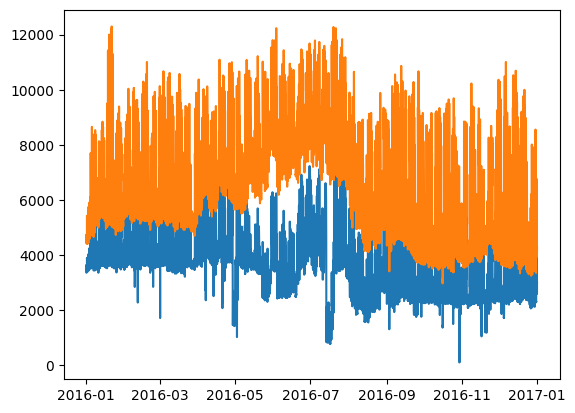

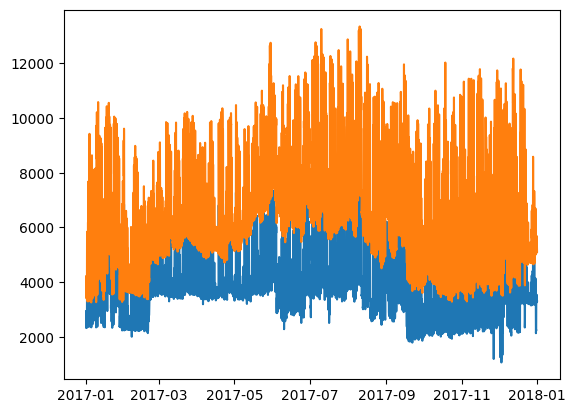

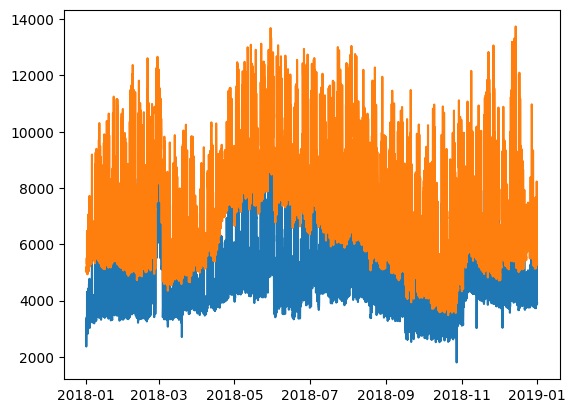

In [32]:
from examples.mix_analysis.analysis_functions import generate_data

# Allows to run this notebook from another notebook without generating the data again (using %run)
if 'skip_generation' not in globals():
    flows, prods, mixs, prod_impacts, impacts = generate_data(my_config, years, savedir="./mix_analysis/results_local_no_enr/")
else:
    print("Skipping data generation")

In [6]:
prods['2021']['CH']

,Residual_Hydro_Water_Reservoir_CH,Residual_Hydro_Run-of-river_and_poundage_CH,Residual_Other_CH,Biomass_CH,Fossil_Brown_coal/Lignite_CH,Fossil_Coal-derived_gas_CH,Fossil_Gas_CH,Fossil_Hard_coal_CH,Fossil_Oil_CH,Fossil_Oil_shale_CH,...,Hydro_Run-of-river_and_poundage_CH,Hydro_Water_Reservoir_CH,Marine_CH,Nuclear_CH,Other_fossil_CH,Other_renewable_CH,Solar_CH,Waste_CH,Wind_Offshore_CH,Wind_Onshore_CH
2021-01-01 00:00:00,0.065104,0.137802,0.048311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023956,0.052193,0.0,0.620001,0.0,0.0,0.000026,0.0,0.0,0.003512
2021-01-01 01:00:00,0.066028,0.139758,0.049050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024437,0.047560,0.0,0.637017,0.0,0.0,0.000026,0.0,0.0,0.002732
2021-01-01 02:00:00,0.067795,0.143499,0.050468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025042,0.042447,0.0,0.647274,0.0,0.0,0.000023,0.0,0.0,0.002352
2021-01-01 03:00:00,0.066144,0.140004,0.049208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025039,0.037393,0.0,0.664670,0.0,0.0,0.000024,0.0,0.0,0.001297
2021-01-01 04:00:00,0.064445,0.136408,0.047903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026657,0.040065,0.0,0.663896,0.0,0.0,0.000027,0.0,0.0,0.001213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.113894,0.147727,0.079802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034570,0.035163,0.0,0.435539,0.0,0.0,0.000032,0.0,0.0,0.006230
2021-12-31 20:00:00,0.120433,0.156209,0.084381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037286,0.029320,0.0,0.472021,0.0,0.0,0.000036,0.0,0.0,0.005806
2021-12-31 21:00:00,0.117671,0.152626,0.082455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038957,0.039658,0.0,0.491980,0.0,0.0,0.000026,0.0,0.0,0.005891
2021-12-31 22:00:00,0.126122,0.163587,0.088373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040846,0.045846,0.0,0.518130,0.0,0.0,0.000032,0.0,0.0,0.006813


In [7]:
prods['2021']['CH'].resample('Y').mean()['Residual_Other_CH']

2021-12-31    0.050516
Freq: A-DEC, Name: Residual_Other_CH, dtype: float64

In [8]:
mixs['2021']['CH'].resample('Y').mean()['Residual_Other_CH']

2021-12-31    0.042762
Freq: A-DEC, Name: Residual_Other_CH, dtype: float64

#### 0.2 Load data from saved files
If the files for the years of interest have already been generated, they can be loaded directly in this section

In [5]:
from examples.mix_analysis.analysis_functions import load_data

flows, prods, mixs, prod_impacts, impacts = load_data(my_config, years, savedir="../examples/mix_analysis/results_local/")

### 0.3 Pre-processing the data
Here we reformat the data to make it easier to manipulate and plot

In [9]:
from ecodynelec.pipeline_functions import get_producing_mix_kwh, get_consuming_mix_kwh

# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country

raw_productions_by_src = {}
# Dict of dicts containing for each target country:
# 'raw_df': Productions in MWh for each power source in each country, contributing to the target
# 'df': Total consumption in the target country (column 'sum') and contribution of each country (MWh)
raw_consumptions_by_src = {}
electricity_prod_mixs = {}
# Dict of dicts containing for each target country:
# 'raw_df': Shares of each power source in the total mix of the target country (0-1)
# 'df': Shares of each country in the total mix of the target country (0-1)
electricity_mixs = {}
# Dict of dicts containing for each target country:
# 'raw_df': Share of ghg emissions of each power source (gCO2eq from this source for one kWh consumed in the target country). This is **not** the ghg emissions for one kWh produced by this source.
# 'df': Ghg emissions in gCO2eq/kWh of the target country consumption mix (column 'sum') and contribution of each country in this mix (gCO2eq for one kWh consumed in the target country)
electricity_impacts = {}
# Dict of dataframes containing for each country the ghg emissions of one kWh produced in that country (gCO2eq/kWh) (it's the impact of the producing mix of each country)
producing_electricity_impacts = {}

raw_prods = {}
# Temporary dict matching raw_consumptions_by_src['raw_df'] but by year
raw_cons = {}
# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for c in my_config.target:
        for y in years:
            raw_prods[y] = {}
            raw_prods[y][c] = get_producing_mix_kwh(flows_df=flows[y][c], prod_mix_df=prods[y][c])
            raw_cons[y] = {}
            raw_cons[y][c] = get_consuming_mix_kwh(flows_df=flows[y][c], mix_df=mixs[y][c])
            # todo et la conso ?
            # todo don't use mix_to_kwh
        raw_productions_by_src[c] = format_data_0({y: raw_prods[y][c] for y in years})
        raw_consumptions_by_src[c] = format_data_0({y: raw_cons[y][c] for y in years})
        electricity_prod_mixs[c] = format_data_0({y: prods[y][c] for y in years})
        electricity_mixs[c] = format_data_0({y: mixs[y][c] for y in years})
        electricity_impact = format_data_0({y: impacts[y][c] for y in years})
        producing_electricity_impact = format_data_0({y: prod_impacts[y][c] for y in years})
        # old producing_electricity_impact = electricity_impact['df'][c] / electricity_mixs[c]['df'][c]
        # convert kgCO2eq/kWh -> gCO2eq/kWh
        electricity_impacts[c] = {k: v * 1000 for k, v in electricity_impact.items()}
        producing_electricity_impacts[c] = {k: v * 1000 for k, v in producing_electricity_impact.items()}
        # old producing_electricity_impacts[c] = producing_electricity_impact * 1000

    # Extract the data for CH
    raw_production_by_src = raw_productions_by_src['CH']
    raw_consumption_by_src = raw_consumptions_by_src['CH']
    electricity_prod_mix = electricity_prod_mixs['CH']
    electricity_mix = electricity_mixs['CH']
    electricity_impact = electricity_impacts['CH']
    producing_electricity_impact = producing_electricity_impacts['CH']#pd.DataFrame(producing_electricity_impacts)
else:  # Easy case: only one target country (not that figure 6 and table 4 will not be available)
    for y in years:
        raw_prods[y] = get_producing_mix_kwh(flows_df=flows[y], prod_mix_df=prods[y])
        raw_cons[y] = get_consuming_mix_kwh(flows_df=flows[y], mix_df=mixs[y])
    raw_production_by_src = format_data_0({y: raw_prods[y] for y in years})
    raw_consumption_by_src = format_data_0({y: raw_cons[y] for y in years})
    electricity_prod_mix = format_data_0({y: prods[y] for y in years})
    electricity_mix = format_data_0({y: mixs[y] for y in years})
    electricity_impact = format_data_0({y: impacts[y] for y in years})
    producing_electricity_impact = format_data_0({y: prod_impacts[y] for y in years})
    # old producing_electricity_impact = electricity_impact['df'] / electricity_mix['df']
    # convert kgCO2eq/kWh -> gCO2eq/kWh
    electricity_impact = {k: v * 1000 for k, v in electricity_impact.items()}
    producing_electricity_impact = {k: v * 1000 for k, v in producing_electricity_impact.items()}
    # old producing_electricity_impact = producing_electricity_impact * 1000
del raw_prods, raw_cons

Over total kwh 2016-01-01 00:00:00    4728.121969
2016-01-01 01:00:00    4586.255944
2016-01-01 02:00:00    4558.943809
2016-01-01 03:00:00    4495.619923
2016-01-01 04:00:00    4536.367263
                          ...     
2016-12-31 19:00:00    4581.590934
2016-12-31 20:00:00    4903.441912
2016-12-31 21:00:00    3944.219008
2016-12-31 22:00:00    4129.003095
2016-12-31 23:00:00    4283.155574
Name: production, Length: 8784, dtype: float64
Over total kwh 2016-01-01 00:00:00    6924.753369
2016-01-01 01:00:00    7033.930944
2016-01-01 02:00:00    6923.001709
2016-01-01 03:00:00    6675.741223
2016-01-01 04:00:00    6625.919263
                          ...     
2016-12-31 19:00:00    7322.658934
2016-12-31 20:00:00    7072.261312
2016-12-31 21:00:00    7137.637008
2016-12-31 22:00:00    7139.992095
2016-12-31 23:00:00    7094.397074
Length: 8784, dtype: float64
Over total kwh 2017-01-01 00:00:00    4214.981242
2017-01-01 01:00:00    3845.390241
2017-01-01 02:00:00    3723.582913
2017

### 0.4 Plots configuration

Some color codes for each country

In [10]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'gray',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
colormap_extended = colormap | {
    'Nuclear_CH': '#8c564b',
    'Residual_Hydro_Run-of-river_and_poundage_CH': '#000080',  # Couleur bleu marine
    'Residual_Hydro_Water_Reservoir_CH': '#004090',  # Couleur bleu marine
    'Hydro_Water_Reservoir_CH': '#98df8a',
    'Residual_Other_CH': '#ffbb78',
    'Hydro_Pumped_Storage_CH': '#bcbd22',
    'Hydro_Run-of-river_and_poundage_CH': '#17becf',
    'Solar_CH': '#d62728',
    'Other_CH': '#1f77b4'
}
ordered_colors = [colormap[c] for c in ordered_countries]

## 1. Inter-annual analysis

Swiss annual electricity consumption

In [11]:
yearly_cons = raw_consumption_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_cons.index = pd.Series(years)
print('Consumption:')
print(yearly_cons)

yearly_prod = raw_production_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_prod.index = pd.Series(years)
print('Production:')
print(yearly_prod)

Consumption:
2016    63491.67 GWh
2017    64681.43 GWh
2018    63912.47 GWh
2019    63798.96 GWh
2020    62510.60 GWh
2021    64668.33 GWh
dtype: object
Production:
2016    59077.53 GWh
2017    58639.06 GWh
2018    65186.34 GWh
2019    69672.99 GWh
2020    67708.50 GWh
2021    61772.69 GWh
dtype: object


Monthly electricity consumption in 2021

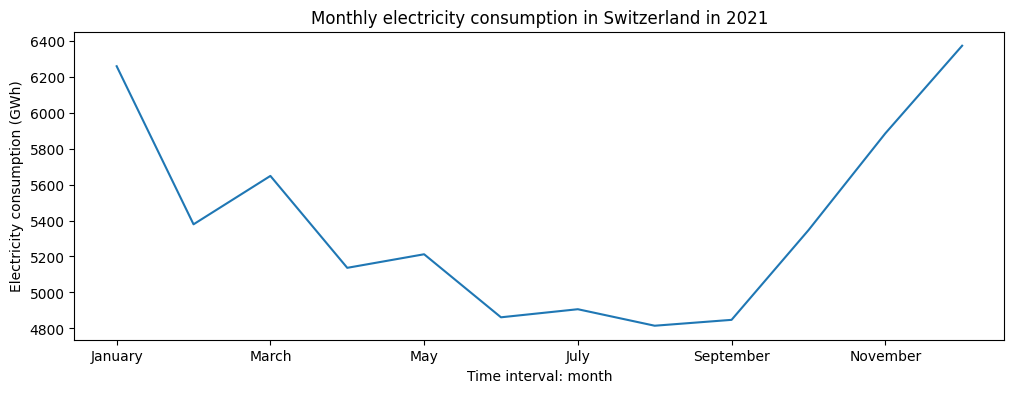

In [12]:
monthly_cons = raw_consumption_by_src['raw_df']
monthly_cons = monthly_cons.loc[[d.year == 2021 for d in monthly_cons.index]]
monthly_cons = monthly_cons.resample('M').sum().sum(axis=1).map(
    lambda x: x / 1000)  #.map(lambda x: f'{x / 1000:.2f} GWh')
monthly_cons.index = [f'{d.month_name()}' for d in monthly_cons.index]
#print(monthly_prod)
monthly_cons.plot(figsize=(12, 4), title='Monthly electricity consumption in Switzerland in 2021')
plt.xlabel('Time interval: month')
plt.ylabel('Electricity consumption (GWh)');

2021 Monthly production from selected sources (helps to validate the data)

In [13]:
ch_prod_raw = {}
# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for y in years:
        #ch_prod_raw[y] = mix_to_kwh(my_config, flows_df=flows[y]['CH'], mix_df=prods[y]['CH'], target='CH', return_data='+P')
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y]['CH'], prod_mix_df=prods[y]['CH'])
else:
    for y in years:
        #ch_prod_raw[y] = mix_to_kwh(my_config, flows_df=flows[y], mix_df=prods[y], target='CH', return_data='+P')
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y], prod_mix_df=prods[y])
ch_prod_raw = format_data_0({y: ch_prod_raw[y] for y in years})['raw_df']
cols = ['Solar_CH', 'Nuclear_CH', 'Wind_Onshore_CH']  # ['Residual_Hydro_Water_Reservoir_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Other_CH'] ...
start = '2020-01-01'
end = '2020-12-31'
monthly_prod = ch_prod_raw[cols][start:end].resample('M').sum()
del ch_prod_raw
monthly_prod/1000

Over total kwh 2016-01-01 00:00:00    4728.121969
2016-01-01 01:00:00    4586.255944
2016-01-01 02:00:00    4558.943809
2016-01-01 03:00:00    4495.619923
2016-01-01 04:00:00    4536.367263
                          ...     
2016-12-31 19:00:00    4581.590934
2016-12-31 20:00:00    4903.441912
2016-12-31 21:00:00    3944.219008
2016-12-31 22:00:00    4129.003095
2016-12-31 23:00:00    4283.155574
Name: production, Length: 8784, dtype: float64
Over total kwh 2017-01-01 00:00:00    4214.981242
2017-01-01 01:00:00    3845.390241
2017-01-01 02:00:00    3723.582913
2017-01-01 03:00:00    3578.000968
2017-01-01 04:00:00    3478.807084
                          ...     
2017-12-31 19:00:00    5434.246052
2017-12-31 20:00:00    5320.895003
2017-12-31 21:00:00    5230.952269
2017-12-31 22:00:00    5215.794918
2017-12-31 23:00:00    5119.281699
Name: production, Length: 8760, dtype: float64
Over total kwh 2018-01-01 00:00:00    5159.791282
2018-01-01 01:00:00    5184.075297
2018-01-01 02:00:00  

,Solar_CH,Nuclear_CH,Wind_Onshore_CH
2020-01-31,86.611093,2231.405996,15.631811
2020-02-29,118.939483,2086.506992,24.123696
2020-03-31,224.359137,2230.835800,15.891792
2020-04-30,328.650170,2016.933198,7.161390
2020-05-31,353.635169,1988.290499,9.613277
2020-06-30,314.263125,1500.136601,8.150604
2020-07-31,366.099837,1245.160100,7.130528
2020-08-31,303.704766,1654.972088,7.124174
2020-09-30,240.506252,2103.930693,7.850673
2020-10-31,139.187923,2195.279294,15.270487


Main power sources in the Swiss electricity mix

In [14]:
yearly_mix = electricity_mix['raw_df'].resample('Y').mean()
local_cols = yearly_mix.mean().nlargest(20).index.tolist()
yearly_mix = yearly_mix.applymap(lambda x: f'{x * 100:.0f} %')
yearly_mix.index = pd.Series(years)
print(yearly_mix[local_cols])

     Nuclear_CH Residual_Hydro_Run-of-river_and_poundage_CH   
2016       21 %                                        21 %  \
2017       20 %                                        18 %   
2018       25 %                                        19 %   
2019       24 %                                        19 %   
2020       24 %                                        20 %   
2021       20 %                                        18 %   

     Hydro_Water_Reservoir_CH Nuclear_FR Hydro_Pumped_Storage_CH   
2016                      8 %        7 %                     5 %  \
2017                      8 %        7 %                     6 %   
2018                     10 %        6 %                     6 %   
2019                     10 %        7 %                     6 %   
2020                     11 %        7 %                     6 %   
2021                     10 %        8 %                     6 %   

     Residual_Other_CH Fossil_Brown_coal/Lignite_DE Solar_CH Nuclear_DE   
2016  

Consumed electricity by country of origin and associated GHG emissions

In [15]:
producing_electricity_impact

{'raw_df':                      Residual_Hydro_Water_Reservoir_CH   
 2016-01-01 00:00:00                           0.250806  \
 2016-01-01 01:00:00                           0.251743   
 2016-01-01 02:00:00                           0.244173   
 2016-01-01 03:00:00                           0.251922   
 2016-01-01 04:00:00                           0.263268   
 ...                                                ...   
 2021-12-31 19:00:00                           0.429246   
 2021-12-31 20:00:00                           0.433892   
 2021-12-31 21:00:00                           0.394774   
 2021-12-31 22:00:00                           0.411803   
 2021-12-31 23:00:00                           0.421089   
 
                      Residual_Hydro_Run-of-river_and_poundage_CH   
 2016-01-01 00:00:00                                     0.166060  \
 2016-01-01 01:00:00                                     0.166680   
 2016-01-01 02:00:00                                     0.161668   
 201

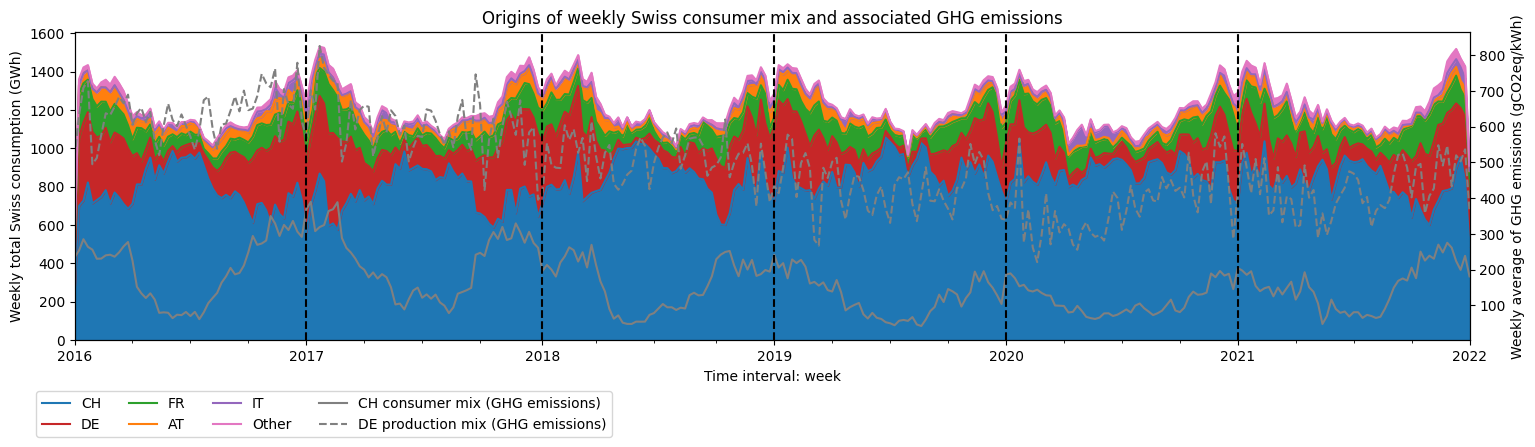

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Origins of weekly Swiss consumer mix and associated GHG emissions")
mix_import = electricity_mix['df'].drop(['sum'], axis=1)
mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('W').sum() / 1000
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('Weekly total Swiss consumption (GWh)')

ax2 = ax1.twinx()
ch_consumer_impact = (electricity_impact['df']['sum']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
ch_consumer_impact.plot(ax=ax2, linestyle='-', color=[colormap['sum']])
de_producing_impact = (producing_electricity_impacts['DE']['df']['sum']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
de_producing_impact.plot(ax=ax2, linestyle='--', color=[colormap['sum']])
ax2.set_ylabel('Weekly average of GHG emissions (gCO2eq/kWh)')

plot_years()

fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
           np.concatenate([ax1.get_legend_handles_labels()[1],
                           ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
           loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

Mix by source (import source and main CH production sources)

lc cols ['Nuclear_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Hydro_Water_Reservoir_CH', 'Hydro_Pumped_Storage_CH', 'Residual_Other_CH', 'Solar_CH']


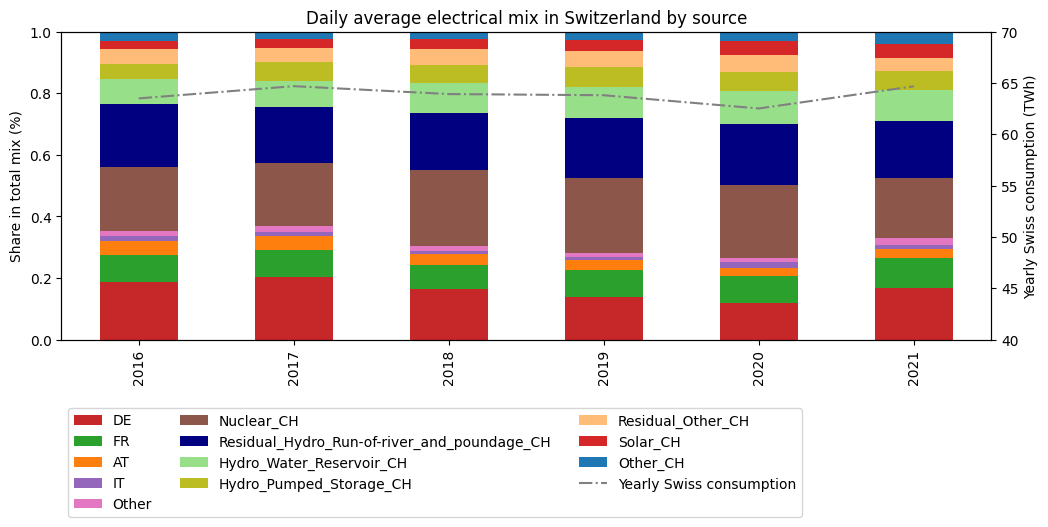

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

# import mix
compute_mix = electricity_mix['df'][ordered_countries].drop('CH', axis=1)
# local CH mix
local_mix = electricity_mix['raw_df']  # wtf .resample('W').mean()
local_mix = local_mix.drop(local_mix.loc[:, [not k.endswith('CH') or 'Mix' in k for k in local_mix.columns]], axis=1)
local_cols = local_mix.mean().nlargest(len(ordered_countries)).index.tolist()
print('lc cols', local_cols)
local_mix['Other_CH'] = local_mix.drop(local_cols, axis=1).sum(axis=1)
# merged mix
compute_mix = pd.concat([compute_mix, local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')
colors = [colormap_extended[c] for c in compute_mix.columns]
# yearly consumption (TWh), used for comparison
yearly_consumption = raw_consumption_by_src['df']['sum'].resample('Y').sum() / 1e6
yearly_consumption.index = metric_values[metric].index  # keep same x axis
# plot
ax2 = ax.twinx()
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, color=colors, legend=True)
yearly_consumption.plot(ax=ax2, linestyle='-.', color='gray', legend=False, label='Yearly Swiss consumption')
ax.set_title(f'Daily average electrical mix in Switzerland by source')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 1)
ax2.set_ylabel('Yearly Swiss consumption (TWh)')
ax2.set_ylim(40, 70)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
handles.append(ax2.get_lines()[0])
labels.append(ax2.get_legend_handles_labels()[1][0])
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2))

Impact of consumption mix over five years

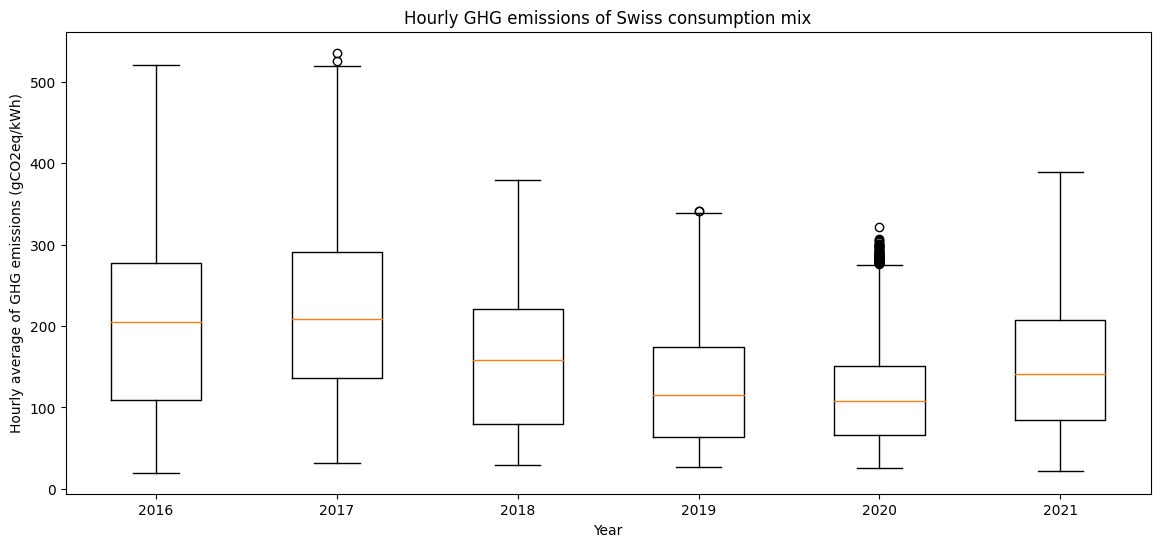

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
data = electricity_impact['df'].astype('float32')
data = pd.DataFrame(data['sum'])
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss consumption mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Impact of production mix over five years

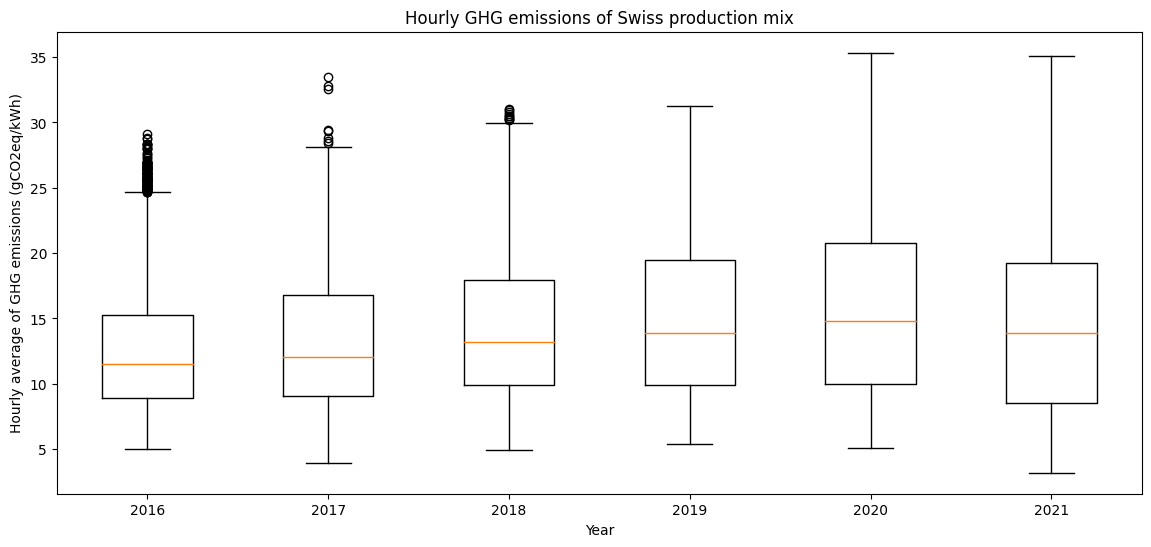

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
data = producing_electricity_impact['raw_df'].astype('float32')
data = data.drop(data.loc[:, [not k.endswith('CH') or 'Mix' in k for k in data.columns]], axis=1)
data = pd.DataFrame(data.sum(axis=1))
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss production mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Figure 6, comparison between the producing impacts of several countries and the import mix of Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

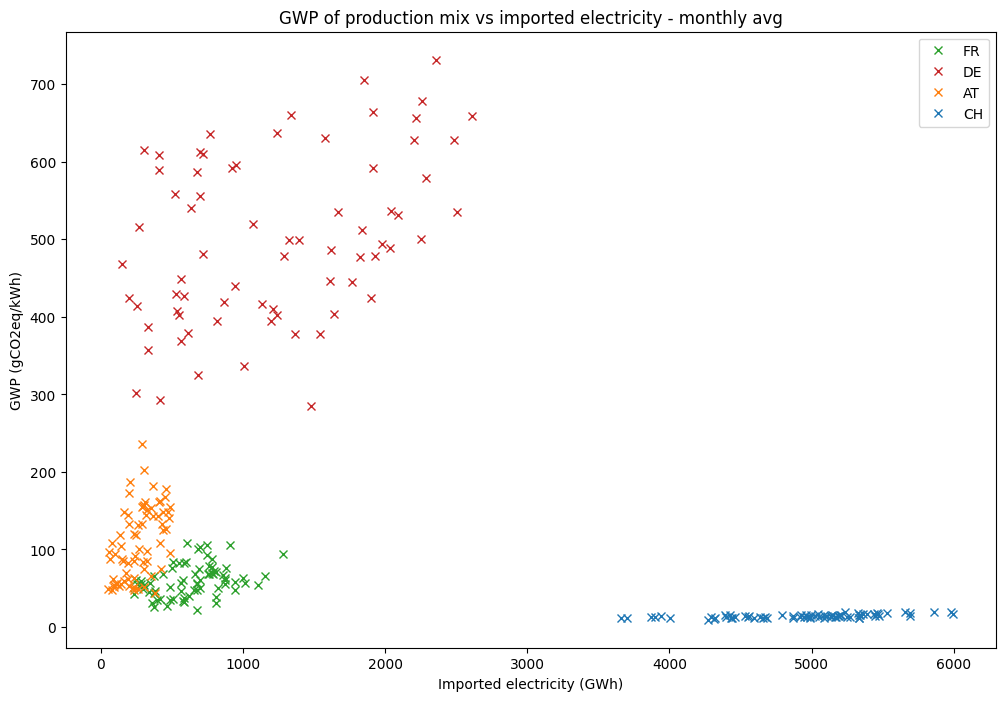

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0, 1, 100)
countries = ['FR', 'DE', 'AT', 'CH']
for c in countries:
    #mx = electricity_mixs['CH']['df'][c].resample('M').mean()
    mx = raw_consumptions_by_src['CH']['df'][c].resample('M').mean()
    px = producing_electricity_impacts[c]['df']['sum'].resample('M').mean()
    plt.plot(mx, px, color=colormap[c], label=c, marker='x', linestyle='None')
plt.title('GWP of production mix vs imported electricity - monthly avg')
plt.xlabel('Imported electricity (GWh)')
plt.ylabel('GWP (gCO2eq/kWh)')
plt.legend();

Table 4, comparison between the producing impacts of several countries an the impacts of imports in Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

In [21]:
countries = ['FR', 'DE', 'AT']
table = {}
freq = 'Y'
for c in countries:
    table[c + '_prod'] = producing_electricity_impacts[c]['df']['sum'].resample(freq).mean()
for c in countries:
    emitted_co2 = producing_electricity_impacts[c]['df']['sum'].multiply(raw_consumptions_by_src['CH']['df'][c])
    emitted_co2 = emitted_co2.resample(freq).sum() / raw_consumptions_by_src['CH']['df'][c].resample(freq).sum()
    table[c + '_import'] = emitted_co2
    #table[c + '_import'] = electricity_impact['df'][c].resample(freq).mean()
tabled = pd.DataFrame(table)
for c in countries:
    tabled[c + '_diff'] = (tabled[c + '_import'].astype(float) - tabled[c + '_prod'].astype(float)) / tabled[
        c + '_prod'].astype(float) * 100
tabled = tabled.applymap(lambda val: f'{val:.2f}').T
ordered_table = tabled.loc[
    ['AT_prod', 'AT_import', 'AT_diff', 'FR_prod', 'FR_import', 'FR_diff', 'DE_prod', 'DE_import', 'DE_diff']]
ordered_table.index = ['AT production mix impact', 'Impact of AT electricity consumed in CH', 'Difference (%)',
                       'FR production mix impact', 'Impact of FR electricity consumed in CH', 'Difference (%)',
                       'DE production mix impact', 'Impact of DE electricity consumed in CH', 'Difference (%)']

In [22]:
ordered_table

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31
AT production mix impact,109.73,112.00,107.18,114.41,105.55,103.00
Impact of AT electricity consumed in CH,116.38,120.94,130.59,117.22,105.42,116.10
Difference (%),6.05,7.98,21.84,2.46,-0.13,12.72
FR production mix impact,65.30,75.35,55.33,55.67,55.31,54.66
Impact of FR electricity consumed in CH,69.05,80.35,54.97,51.93,53.11,52.98
Difference (%),5.74,6.63,-0.65,-6.72,-3.98,-3.07
DE production mix impact,635.67,609.23,513.85,427.75,379.33,427.63
Impact of DE electricity consumed in CH,643.47,610.62,505.98,417.07,361.58,427.82
Difference (%),1.23,0.23,-1.53,-2.50,-4.68,0.04


## 2. Intra-annual analysis

Heatmaps of :
- CH consumption
- DE and FR imports
- Consumption from hydro production (pumped storage and water reservoir)

The exported electricity is not taken into account in these figures.

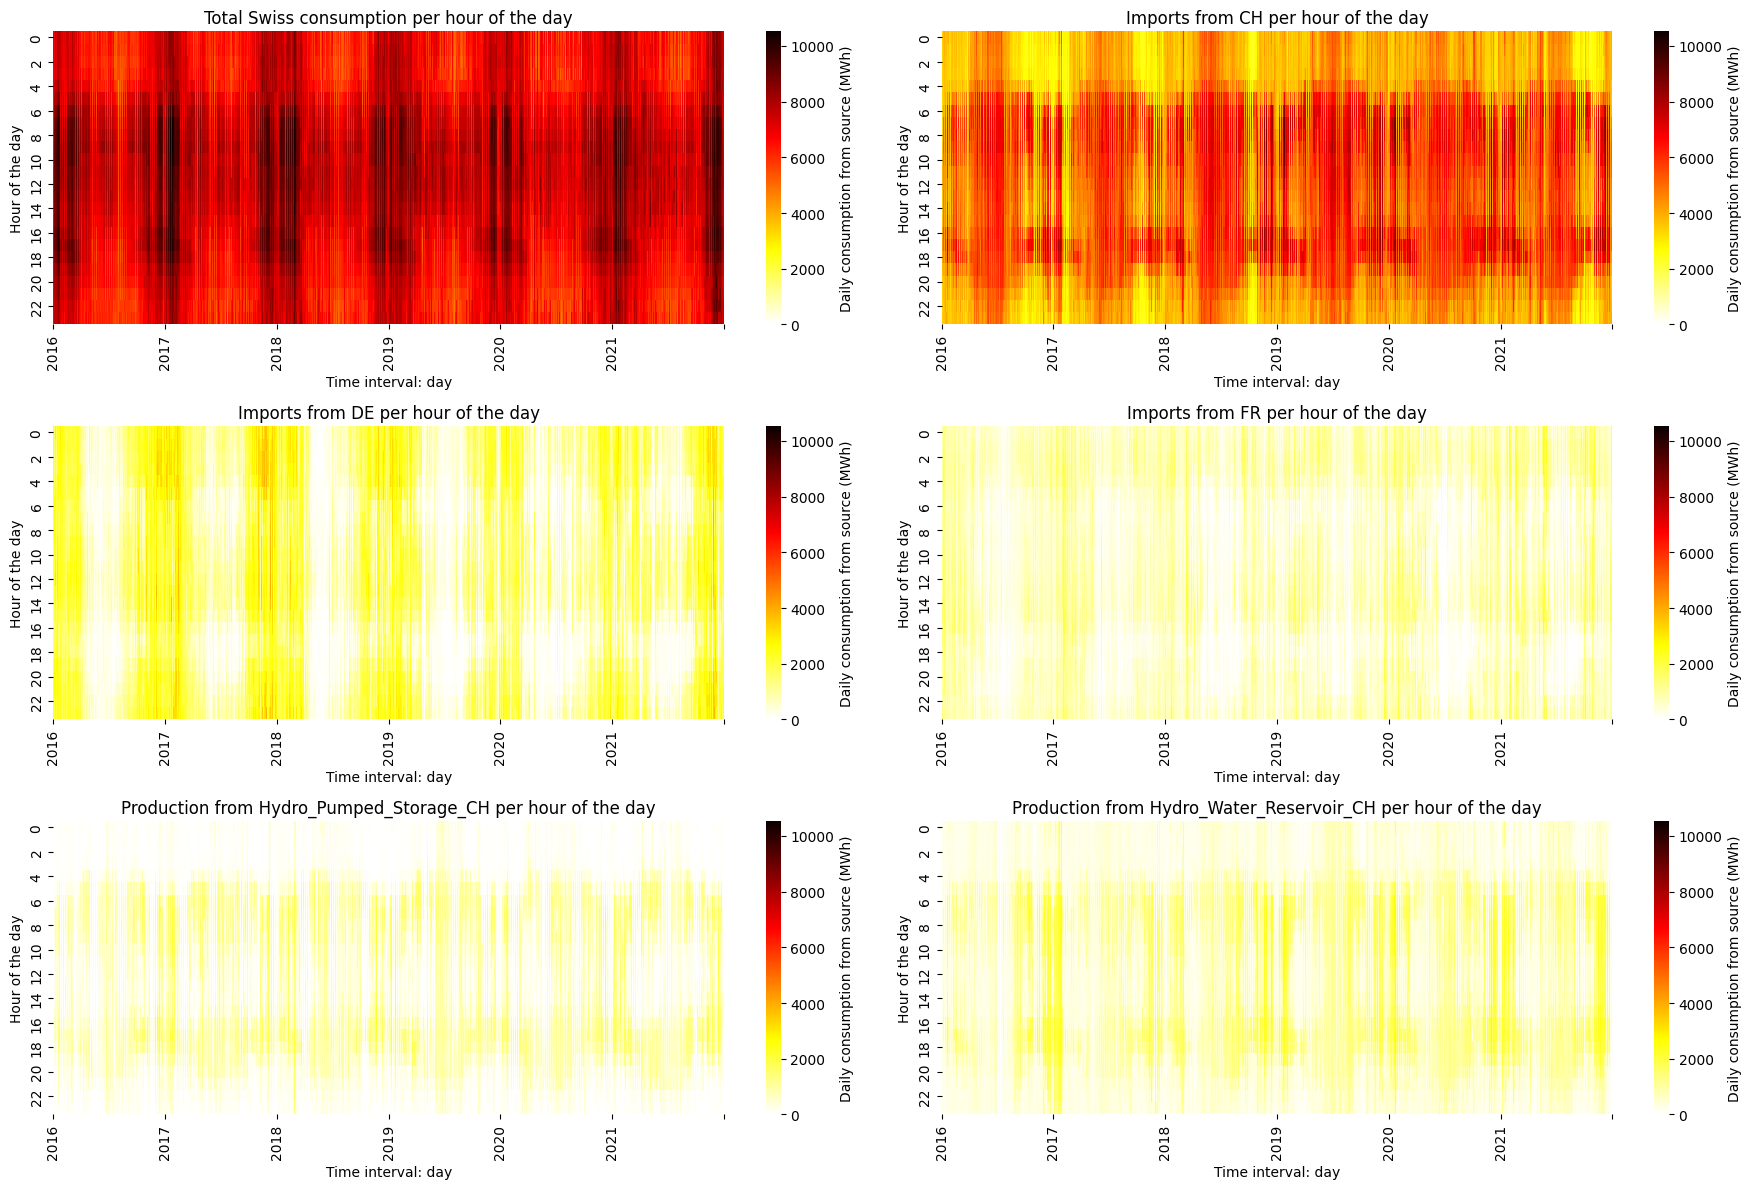

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))
countries = ['sum', 'CH', 'DE', 'FR']
# Heatmap import
data = raw_consumption_by_src['df'][countries].copy()
val_max = data[countries].max().max()
for i in range(len(countries)):
    series = data[countries[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data, countries[i], xlabels, 'Imports from ' + countries[i],
                        'Daily consumption from source (MWh)', val_max=val_max, fig=fig, ax=ax[i // 2, i % 2])

ax[0, 0].set_title('Total Swiss consumption per hour of the day')

# Heatmap hydro
cols = ['Hydro_Pumped_Storage_CH', 'Hydro_Water_Reservoir_CH']
data2 = raw_consumption_by_src['raw_df'][cols].astype(float)
for i in range(len(cols)):
    series = data2[cols[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data2, cols[i], xlabels, 'Production from ' + cols[i], 'Daily consumption from source (MWh)',
                        val_max=val_max, fig=fig, ax=ax[2, i])

fig.tight_layout()

Heatmap of the carbon emissions associated to the Swiss consumption mix :

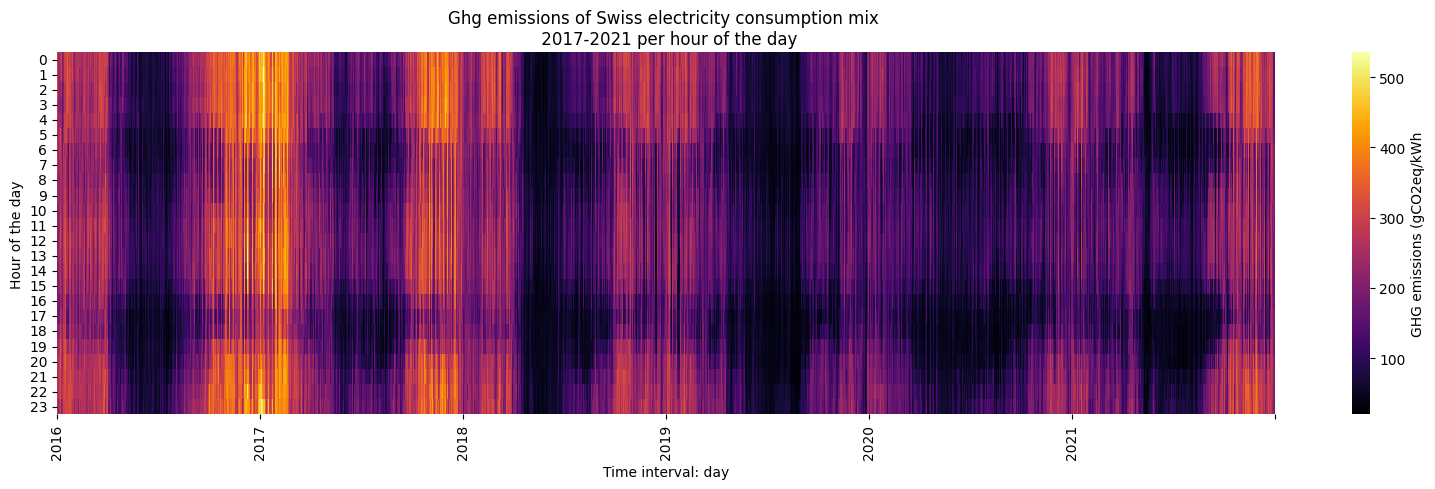

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Heatmap import
data = electricity_impact['df'][['sum']].copy()
val_mean = data['sum'].loc['2021-01-01':'2021-12-31'].mean()
#data = (data - val_mean) / val_mean * 100
val_min = -100
val_max = 300
val_min = data.min().min()
val_max = data.max().max()
series = data['sum']
xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
plot_hourly_heatmap(data, 'sum', xlabels,
                    'Ghg emissions of Swiss electricity consumption mix \n 2017-2021', 'GHG emissions (gCO2eq/kWh', val_min=val_min,
                    val_max=val_max, fig=fig, ax=ax, cmap='inferno')
fig.tight_layout()

Yearly average of carbon emissions per consumed kWh :
**Warning** the data before 2020 is mis-estimated because of the lack of knowledge on the composition of the residual

In [25]:
yearly_mean = producing_electricity_impact['df'][['sum']].groupby(producing_electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,12.515796
2017,13.285932
2018,14.297060
2019,14.979635
2020,15.682049
2021,14.344045


In [26]:
yearly_mean = electricity_impact['df'][['sum']].groupby(electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,201.695582
2017,218.678944
2018,157.926660
2019,125.461919
2020,114.812464
2021,151.918957


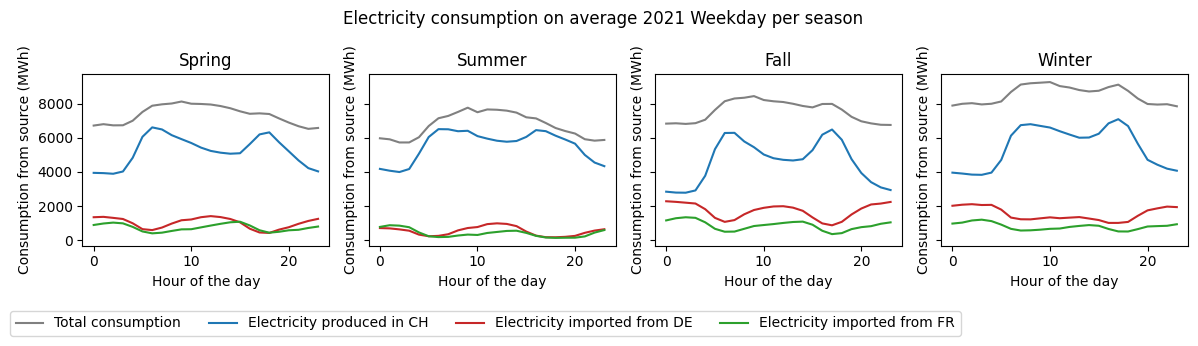

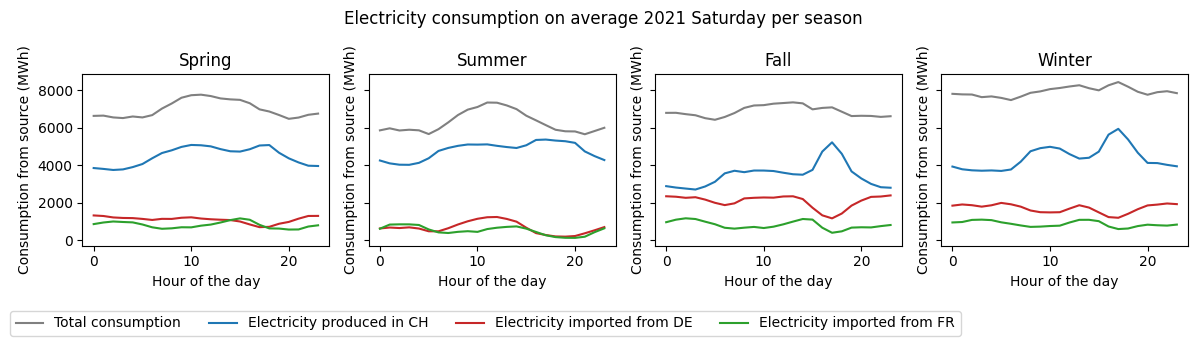

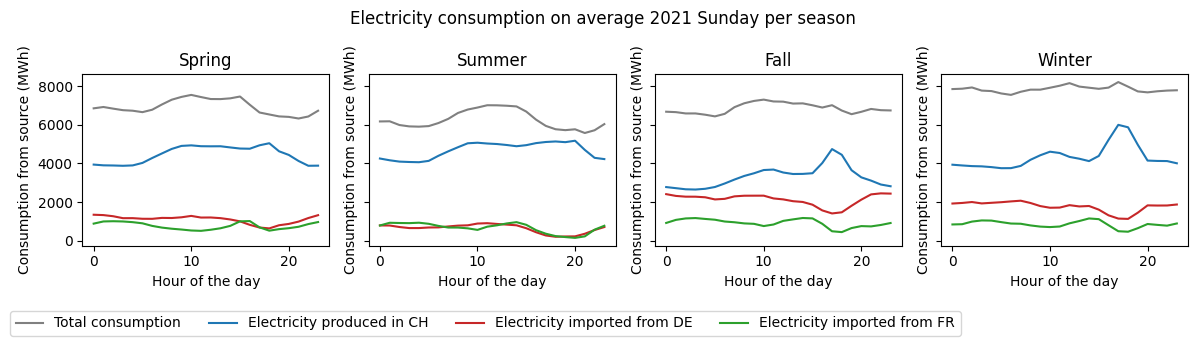

In [27]:
countries = ['sum', 'CH', 'DE', 'FR']
start = '2021-01-01'
end = '2021-12-31'
years_label = '2021'
data = raw_consumption_by_src['df'][countries].loc[start:end].copy()

season_names = {2: 'Spring', 3: 'Summer', 4: 'Fall', 1: 'Winter'}
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

season_labels = [*season_names.values()]
weekdays = ['Weekday', 'Saturday', 'Sunday']
for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek']==k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels, f'Electricity consumption on average {years_label} {weekdays[k]}', 'Consumption from source (MWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total consumption', 'Electricity produced in CH', 'Electricity imported from DE', 'Electricity imported from FR'], loc='upper left', ncol=4, bbox_to_anchor=(0, 0))
    plt.show()

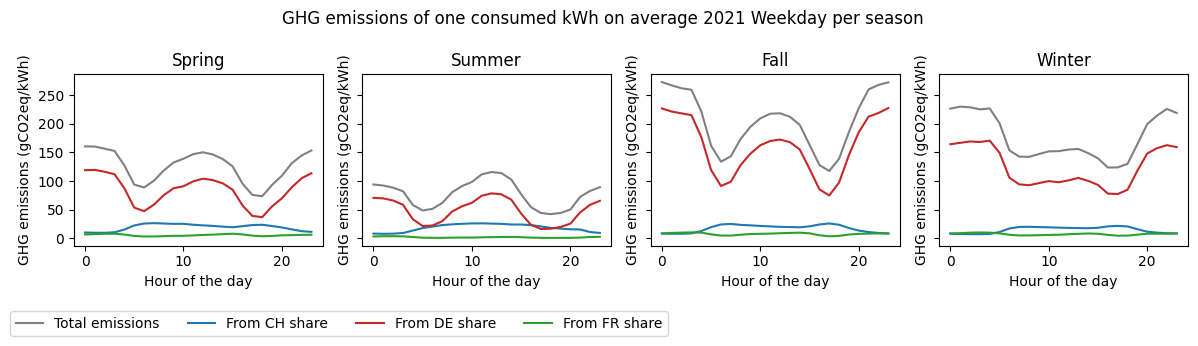

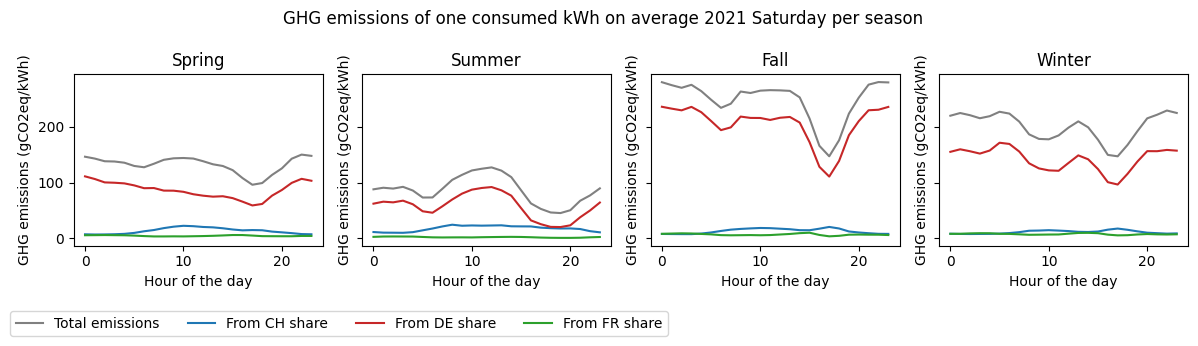

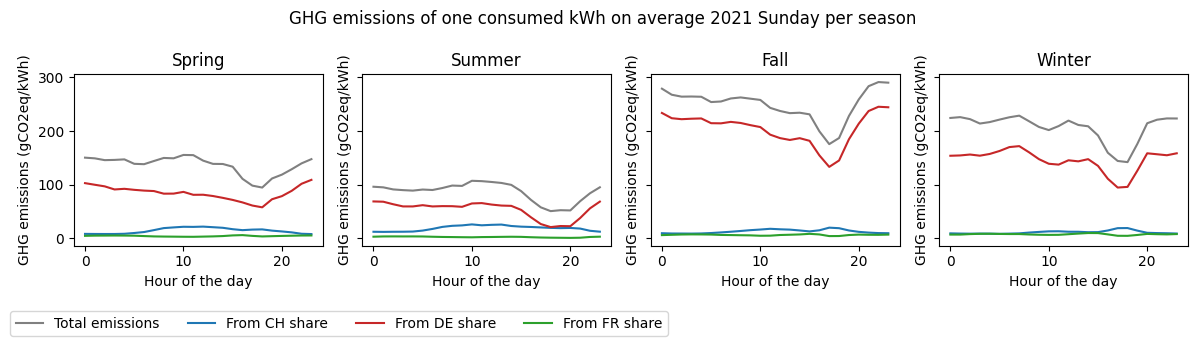

In [28]:
data = electricity_impact['df'][countries].loc[start:end].copy()
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek']==k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels, f'GHG emissions of one consumed kWh on average {years_label} {weekdays[k]}', 'GHG emissions (gCO2eq/kWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total emissions', 'From CH share', 'From DE share', 'From FR share'], loc='upper left', ncol=4, bbox_to_anchor=(0, 0))
    plt.show()

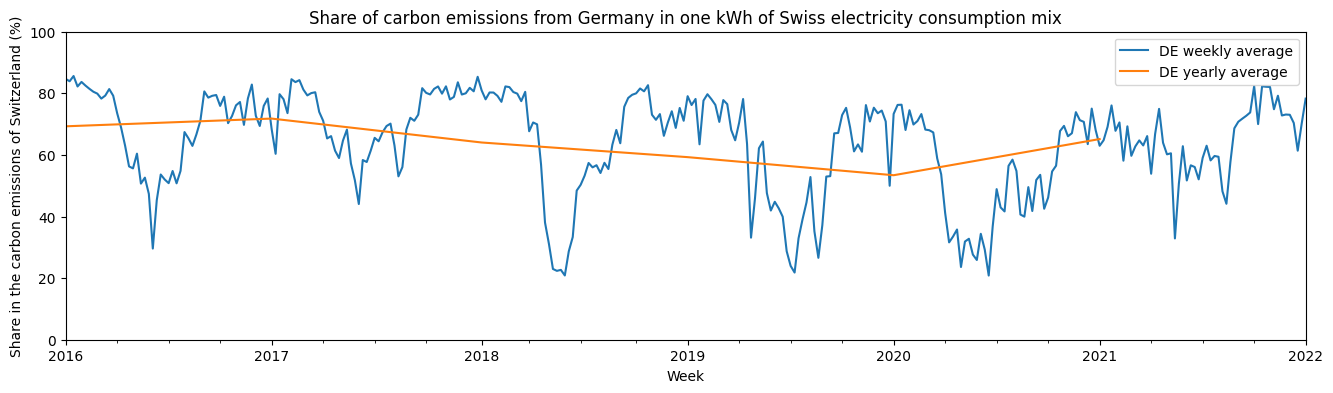

In [45]:
raw_consumption_by_src['df'].resample('Y').sum()

2016-12-31    69.289523
2017-12-31    71.799144
2018-12-31    64.034945
2019-12-31    59.279436
2020-12-31    53.408376
2021-12-31    65.151415
Freq: A-DEC, dtype: float64